In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('transformed.csv', index_col=0)

In [5]:
df.head()

,gender,age,country,education_level,undergrad_major,role,employer_industry,years_experience,yearly_compensation
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000"
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000"
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000"
7,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000"
8,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000"


In [20]:
df_tf = pd.get_dummies(df[[c for c in df.columns if c != 'yearly_compensation']], dummy_na=True)
df_tf.shape

(12956, 149)

In [9]:
target = df['yearly_compensation']

In [24]:
from pandas.api.types import CategoricalDtype

# transforming compensation into category type and ordening the values
categ = ['0-10,000', '10-20,000', '20-30,000', '30-40,000', '40-50,000',
         '50-60,000', '60-70,000', '70-80,000', '80-90,000', '90-100,000',
         '100-125,000', '125-150,000', '150-200,000', '200-250,000', '250-300,000',
         '300-400,000', '400-500,000', '500,000+']
cat_type = CategoricalDtype(categories=categ, ordered=True)
target = target.astype(cat_type)

In [25]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df_tf, target, test_size=.25, random_state=42)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tqdm

In [47]:
models = []
for i, cat in tqdm.tqdm(enumerate(target.cat.categories[:-1])):
#     print(i, cat, categ[:i + 1], categ[i + 1:])
    labels = [0] * len(categ[:i+1]) + [1] * len(categ[i + 1:])
    map = {cat: labels[j] for j, cat in enumerate(categ)}
    new_target = train_y.replace(map)
    mod = LogisticRegression(random_state=42, solver='lbfgs')
    mod.fit(train_X, new_target)
    models.append(mod)

0it [00:00, ?it/s]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
1it [00:01,  1.33s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
3it [00:03,  1.25s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
4it [00:04,  1.26s/it]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
5it [00:06,  1.23s/it]/home/ptyshevskyi/envs

In [272]:
models = []
for i, cat in tqdm.tqdm(enumerate(target.cat.categories[:-1])):
#     print(i, cat, categ[:i + 1], categ[i + 1:])
    labels = [0] * len(categ[:i+1]) + [1] * len(categ[i + 1:])
    map = {cat: labels[j] for j, cat in enumerate(categ)}
    new_target = train_y.replace(map)
    mod = RandomForestClassifier(random_state=42, n_estimators=100)
    mod.fit(train_X, new_target)
    models.append(mod)

17it [00:32,  1.23s/it]


In [277]:
test_y.values[6]

'150-200,000'

In [278]:
single_example = test_X.iloc[6, :]
single_example = single_example.values.reshape(1, -1)

In [279]:
binary_probabilities = [mod.predict_proba(single_example) for mod in models]

In [280]:
neg_probs = [p[0][0] for p in binary_probabilities]
pos_probs = [p[0][1] for p in binary_probabilities]

In [281]:
from functools import reduce

In [282]:
prod = lambda x, y: x * y
reduce(prod, [p[0][0] for p in binary_probabilities])

0.0

In [285]:
bin_probabilities = []
for i in range(len(models)):
    bin_prob = [p for p in pos_probs[:i]] + [p for p in neg_probs[i:]]
    reduced = reduce(prod, bin_prob)
    bin_probabilities.append(reduced)
bin_probabilities.append(reduce(prod, pos_probs))

In [287]:
sm = sum(bin_probabilities)
normalized_probs = [p / sm for p in bin_probabilities]

In [288]:
import numpy as np

In [273]:
def predict_multimodel(X):
    y = []
    for i, row in tqdm.tqdm(X.iterrows()):
        row = row.values.reshape(1, -1)
        binary_probabilities = [mod.predict_proba(row) for mod in models]
        neg_probs = [p[0][0] for p in binary_probabilities]
        pos_probs = [p[0][1] for p in binary_probabilities]
        bin_probabilities = []
        for i in range(len(models)):
            bin_prob = [p for p in pos_probs[:i]] + [p for p in neg_probs[i:]]
            reduced = reduce(prod, bin_prob)
            bin_probabilities.append(reduced)
        bin_probabilities.append(reduce(prod, pos_probs))
        sm = sum(bin_probabilities)
        normalized_probs = [p / sm for p in bin_probabilities]
        y.append(categ[np.argmax(normalized_probs)])
    return y

In [274]:
y_pred = predict_multimodel(test_X)

3239it [08:26,  6.98it/s]


In [275]:
accuracy_score(test_y, y_pred)

0.33991972831120715

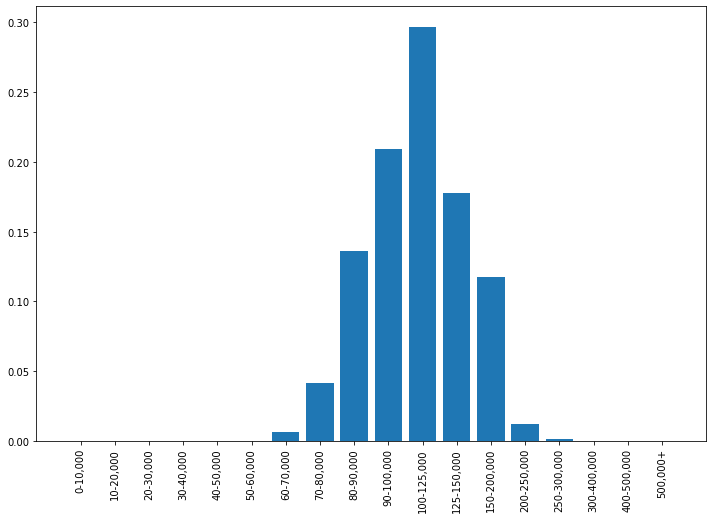

In [289]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.xticks(rotation=90);
plt.bar(categ, normalized_probs);

In [237]:
# lr = LogisticRegression(solver='lbfgs', random_state=42, multi_class='auto')
# lr.fit(train_X, train_y)

In [290]:
lr.predict_proba(single_example)

array([[0.00114341, 0.00312859, 0.19249954, 0.13827439, 0.24687146,
        0.0084752 , 0.06844579, 0.04101452, 0.01813725, 0.0171479 ,
        0.02141465, 0.00055689, 0.02952606, 0.00318699, 0.0376455 ,
        0.03863316, 0.06970892, 0.06418976]])

In [291]:
lr.classes_

array(['0-10,000', '10-20,000', '100-125,000', '125-150,000',
       '150-200,000', '20-30,000', '200-250,000', '250-300,000',
       '30-40,000', '300-400,000', '40-50,000', '400-500,000',
       '50-60,000', '500,000+', '60-70,000', '70-80,000', '80-90,000',
       '90-100,000'], dtype=object)

In [292]:
lr_probs = lr.predict_proba(single_example)

In [293]:
sorted_probs = [lr_probs[0][list(lr.classes_).index(c)] for c in categ]

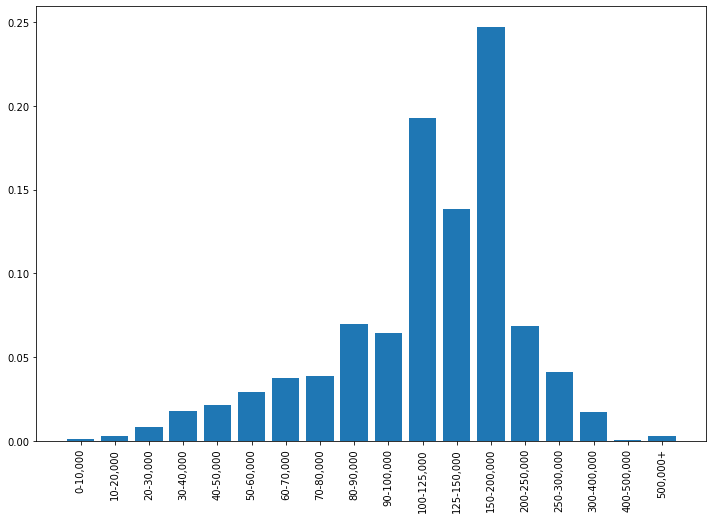

In [294]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.xticks(rotation=90);
plt.bar(categ, sorted_probs);

In [249]:
## Check the perfomance
from sklearn.metrics import accuracy_score
accuracy_score(test_y, lr.predict(test_X))

0.366471133065761

In [251]:
acc

,gender_Female,gender_Male,gender_nan,age_18-21,age_22-24,age_25-29,age_30-34,age_35-39,age_40-44,age_45-49,...,years_experience_1-2,years_experience_10-15,years_experience_15-20,years_experience_2-3,years_experience_20-25,years_experience_25-30,years_experience_3-4,years_experience_4-5,years_experience_5-10,years_experience_nan
4263,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
16986,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
485,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6367,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
14521,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
22978,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4577,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5831,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1172,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7872,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


[0.586068808301321,
 0.8305710089983029,
 0.9244058209027496,
 0.9503867891405675,
 0.959798891143155,
 0.9729759077521815,
 0.9766449332093493,
 0.9790643209730348,
 0.9827485012526916,
 0.986533718925159,
 0.9909277916034878,
 0.9906433577975438,
 0.9895720648515497,
 0.9946745530034252,
 0.9978140996443656,
 0.9989402771681419,
 0.9992888176860782]